# The General Claims Data
- Primary question of interest: Who was at fault?
<br> <br>
- Secondary questions of interest:
    - What Claim Group should the claim be routed to?
    - Can we predict severity type (minor, moderate, major, life threatening, death)
    - What was the cause of the loss?

In [1]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_lg

In [120]:
import matplotlib.pyplot as plt

%matplotlib inline
# Increasing default figure size of the notebook
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 18

In [2]:
import nltk
from nltk import word_tokenize

In [3]:
from nltk.corpus import stopwords
# stop = stopwords.words('english')

In [4]:
stop = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 
 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 
 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 
 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 
 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 
 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 
 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 
 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 
 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'doing', 'it', 'how', 'further', 'was', 
 'here', 'than']

In [5]:
import gensim

In [6]:
# general_tokens_df = pd.read_csv('data/general_with_tokens.csv')

In [7]:
# general_tokens_df.head()

In [8]:
from ast import literal_eval

In [9]:
# def join_strings(df, columns):
#     n_df = df
#     for col in columns:
#         def join_col(row):
#             claim_list = row[col]
#             return ' '.join(claim_list)
#         n_df[col] = n_df.apply(join_col, axis = 1)
#     return n_df
# convert lists from strings back to lists
def convert_to_list(df,cols):
    n_df = df
    for col in cols:
        def de_list(row):
            list_str = row[col]
            return literal_eval(list_str)
        n_df[col] = n_df.apply(de_list, axis = 1)
    return n_df

In [10]:
# general_tokens_df = convert_to_list(general_tokens_df, ['claim_level_list', 'exposure_level_list',
#                                                        'accident_desc_list', 'injury_desc_list',
#                                                        'damage_desc_list'])

In [11]:
general_df = pd.read_csv('data/general_with_word_counts.csv')


In [12]:
general_df.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,...,insd_count,insured_count,rear_count,deployed_count,towed_count,totaled_count,head_count,ambulance_count,concussion_count,whiplash_count
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,...,0,0,0,0,0,0,0,0,0,0
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,...,0,2,0,0,0,0,0,0,0,0
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,...,4,4,1,0,0,0,0,0,0,0
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,...,4,4,1,0,0,0,0,0,0,0
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,...,0,10,0,0,0,0,0,0,0,0


In [144]:
general_df.claim_level_list.head()

0    reviewed coverage sc rated policy loss effecti...
1    c dol tol pm venue fl location jacksonville fl...
2    insured hospital lost service middle claim ins...
3    insured hospital lost service middle claim ins...
4    adjuster office reassigned adjuster office rea...
Name: claim_level_list, dtype: object

In [13]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119272 entries, 0 to 119271
Data columns (total 47 columns):
ClaimID_RGEN                      119272 non-null int64
ExposureID_RGEN                   119272 non-null int64
ClaimLevelBody                    119272 non-null object
ExposureLevelBody                 119272 non-null object
AccidentDescription               119272 non-null object
InjuryDescription                 119272 non-null object
DamageDescription                 119272 non-null object
SeverityTypeName                  86721 non-null object
ClaimGroup                        119257 non-null object
FaultRatingName                   119271 non-null object
LossCauseName                     119272 non-null object
CCCreateTime                      119272 non-null object
CloseDate                         99601 non-null object
StateName                         119272 non-null object
ClaimLevelBody_preprocess         119272 non-null object
ExposureLevelBody_preprocess      1192

In [14]:
# general_no_unknown = general_df.loc[general_df.loc[:,'FaultRatingName'] != 'Fault unknown',:].reset_index(drop=True)

In [15]:
general_df = general_df.fillna({'exposure_level_list':' ', 'injury_desc_list':' ', 'damage_desc_list': ' '})

In [16]:
# general_no_unknown.info()

In [17]:
# nlp = en_core_web_lg.load()

In [18]:
def column_to_list_text(df, col_name):
    return df[col_name].tolist()

In [19]:
def lower_columns(df, col_list):
    n_df = df
    for col_name in col_list:
        n_col = col_name + '_preprocess'
        n_df[n_col] = n_df[col_name].str.lower()
    return n_df

In [20]:
# lowered_df = lower_columns(general_df, ['ClaimLevelBody', 'ExposureLevelBody', 'AccidentDescription', 
#                                         'InjuryDescription', 'DamageDescription'])

In [21]:
# lowered_df.head()

In [22]:
def tokenize_claim_level(row):
#     list_cols = [['ClaimLevelBody_preprocess', 'ExposureLevelBody_preprocess', 'AccidentDescription_preprocess', 
#                                         'InjuryDescription_preprocess', 'DamageDescription_preprocess']]
    text = row['ClaimLevelBody_preprocess']
    text_tokenize = [token for token in word_tokenize(text) if token.isalpha() and token not in stop]
    return text_tokenize
        
def pre_process(df, col_list):
    for col in col_list:
        df[col] = df.apply(lambda x: tokenize(x, col), axis=1)
    return df

In [23]:
#lowered_df['ClaimLevelBody_preprocess'] = lowered_df.apply(tokenize_claim_level, axis = 1)

In [24]:
#out_df.head()

In [25]:
general_df.claim_level_list[0]

'reviewed coverage sc rated policy loss effective dates coverage ni operating vnop vehicle appears loaner veh policy set cx non payment reinstated without lapse send ror citing definition covered auto insuring agreement section liability coverage liability modified compneg state need statements police report complete lia investigation based report loss driver pulled nis row exposure driver appears allstate lets confirm rule umpdumbi exposure appears pd rule injuries clmnt driver determine severity nis injuries secure uim rejection form action plan send ror complete vnop investigation statements confirm ownership veh insurance infomation vnop confirm driver lia coverage rule umpdumbi complete liability investigation statementspolice reportset appraisal needed rule serious injuries secure uim rejection form needed recovery applicable reviewed coverage sc rated policy loss effective dates coverage ni operating vnop vehicle appears loaner veh policy set cx non payment reinstated without la

In [26]:
# lowered_df.head()

In [27]:
fault_ratings = column_to_list_text(general_df, 'FaultRatingName')

In [28]:
claim_level_body = column_to_list_text(general_df, 'claim_level_list')

In [29]:
exposure_level_body = column_to_list_text(general_df, 'exposure_level_list')

In [30]:
accident_description = column_to_list_text(general_df, 'accident_desc_list')

In [31]:
injury_description = column_to_list_text(general_df, 'injury_desc_list')

In [32]:
damage_description = column_to_list_text(general_df, 'damage_desc_list')

In [33]:
# claim_level_tokenized = [[token for token in word_tokenize(doc)] 
#                            for doc in claim_level_body]
# exposure_level_tokenized = [[token for token in word_tokenize(doc)] 
#                            for doc in exposure_level_body]
# accident_desc_tokenized = [[token for token in word_tokenize(doc)] 
#                            for doc in accident_description]
# injury_desc_tokenized = [[token for token in word_tokenize(doc)] 
#                            for doc in injury_description]
# damage_desc_tokenized = [[token for token in word_tokenize(doc) ] 
#                          for doc in damage_description]

# [token for token in word_tokenize(damage_description) if token.isalpha()]

In [34]:
from collections import Counter

In [35]:
# exposure_level_tokenized[4]

In [36]:
# word_counts_claim = [dict(Counter(doc)) for doc in claim_level_tokenized]
# word_counts_exposure = [dict(Counter(doc)) for doc in exposure_level_tokenized]
# word_counts_accident = [dict(Counter(doc)) for doc in accident_desc_tokenized]
# word_counts_injury = [dict(Counter(doc)) for doc in injury_desc_tokenized]
# word_counts_damage = [dict(Counter(doc)) for doc in damage_desc_tokenized]

In [37]:
# word_counts_accident[30052]

In [38]:
# claim_word_counts = [len(doc) for doc in claim_level_tokenized]
# exposure_word_counts = [len(doc) for doc in exposure_level_tokenized]
# accident_word_counts = [len(doc) for doc in accident_desc_tokenized]
# injury_word_counts = [len(doc) for doc in injury_desc_tokenized]
# damage_word_counts = [len(doc) for doc in damage_desc_tokenized]


In [39]:
# iv_list = [0] * len(word_counts_claim)
# liability_list = [0] * len(word_counts_claim)
# dcv_list = [0] * len(word_counts_claim)
# inj_list = [0] * len(word_counts_claim)
# vnop_list = [0] * len(word_counts_claim)
# ac_list = [0] * len(word_counts_claim)
# cv_list = [0] * len(word_counts_claim)
# div_list = [0] * len(word_counts_claim)
# insd_list = [0] * len(word_counts_claim)
# insured_list = [0] * len(word_counts_claim)
# clmt_list = [0] * len(word_counts_claim)

In [40]:
# head_list = [0] * len(word_counts_injury)
# ambulance_list = [0] * len(word_counts_injury)
# concussion_list = [0] * len(word_counts_injury)
# whiplash_list = [0] * len(word_counts_injury)

In [41]:
# rear_list = [0] * len(word_counts_accident)

In [42]:
# deployed_list = [0] * len(word_counts_damage)
# towed_list = [0] * len(word_counts_damage)
# totaled_list = [0] * len(word_counts_damage)

In [43]:
# for ind, count_dict in enumerate(word_counts_accident):
#     if 'rear' in count_dict:
#         rear_list[ind] = count_dict['rear']

In [44]:
# for ind, count_dict in enumerate(word_counts_damage):
#     if 'deployed' in count_dict:
#         deployed_list[ind] = count_dict['deployed']
#     if 'towed' in count_dict:
#         towed_list[ind] = count_dict['towed']
#     if 'totaled' in count_dict:
#         totaled_list[ind] = count_dict['totaled']

In [45]:
# for ind, count_dict in enumerate(word_counts_injury):
#     if 'head' in count_dict:
#         head_list[ind] = count_dict['head']
#     if 'ambulance' in count_dict:
#         ambulance_list[ind] = count_dict['ambulance']
#     if 'concussion' in count_dict:
#         concussion_list[ind] = count_dict['concussion']
#     if 'whiplash' in count_dict:
#         whiplash_list[ind] = count_dict['whiplash']

In [46]:
# for ind, count_dict in enumerate(word_counts_claim):
#     if 'iv' in count_dict:
#         iv_list[ind] = count_dict['iv']
#     else:
#         iv_list[ind] = 0
#     if 'liability' in count_dict:
#         liability_list[ind] = count_dict['liability']
#     else:
#         liability_list[ind] = 0
#     if 'dcv' in count_dict:
#         dcv_list[ind] = count_dict['dcv']
#     else:
#         dcv_list[ind] = 0
#     if 'inj' in count_dict:
#         inj_list[ind] = count_dict['inj']
#     else:
#         inj_list[ind] = 0
#     if 'vnop' in count_dict:
#         vnop_list[ind] = count_dict['vnop']
#     else:
#         vnop_list[ind] = 0
#     if 'ac' in count_dict:
#         ac_list[ind] = count_dict['ac']
#     else:
#         ac_list[ind] = 0
#     if 'cv' in count_dict:
#         cv_list[ind] = count_dict['cv']
#     else:
#         cv_list[ind] = 0
#     if 'div' in count_dict:
#         div_list[ind] = count_dict['div']
#     else:
#         div_list[ind] = 0
#     if 'insd' in count_dict:
#         insd_list[ind] = count_dict['insd']
#     else:
#         insd_list[ind] = 0
#     if 'insured' in count_dict:
#         insured_list[ind] = count_dict['insured']
#     else:
#         insured_list[ind] = 0

In [47]:
# iv_list[:10]

In [48]:
# word_counts_claim[2]

In [49]:
# word_cols = {'claim_level_word_count': claim_word_counts,
#              'exposure_word_count': exposure_word_counts,
#              'accident_desc_word_count': accident_word_counts,
#     'injury_desc_word_count': injury_word_counts,
#              'damage_desc_word_count': damage_word_counts,
#     'iv_count': iv_list,
#          'liability_count': liability_list,
#          'dcv_count': dcv_list,
#          'inj_count': inj_list,
#              'vnop_count': vnop_list,
#             'ac_count': ac_list,
#             'cv_count': cv_list,
#             'div_count': div_list,
#             'insd_count': insd_list,
#             'insured_count': insured_list,
#             'rear_count': rear_list,
#             'deployed_count': deployed_list,
#             'towed_count': towed_list,
#             'totaled_count': totaled_list,
#             'head_count': head_list,
#             'ambulance_count': ambulance_list,
#             'concussion_count': concussion_list,
#             'whiplash_count': whiplash_list}
# df_spec_word_count = pd.DataFrame.from_dict(word_cols)

In [50]:
# df_spec_word_count.head()

In [51]:
# dict_cols = {'word_counts_claim': word_counts_claim,
#          'word_counts_exposure': word_counts_exposure,
#          'word_counts_accident': word_counts_accident,
#          'word_counts_injury': word_counts_injury,
#              'word_counts_damage': word_counts_damage}
# df_word_count = pd.DataFrame.from_dict(dict_cols)

In [52]:
# df_word_count.head()

In [53]:
# token_cols = {'claim_level_list': claim_level_tokenized,
#          'exposure_level_list': exposure_level_tokenized,
#          'accident_desc_list': accident_desc_tokenized,
#          'injury_desc_list': injury_desc_tokenized,
#              'damage_desc_list': damage_desc_tokenized}
# df = pd.DataFrame.from_dict(token_cols)

In [54]:
# df.head()

In [55]:
# len(df)

In [56]:
# df_spec_word_counts = pd.concat([df_with_counts, df_spec_word_count], axis = 1)

In [57]:
# df_with_tokens = pd.concat([lowered_df, df], axis = 1)

In [58]:
# df_with_counts = pd.concat([general_df, df_spec_word_count], axis = 1)

In [59]:
general_df.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,...,insd_count,insured_count,rear_count,deployed_count,towed_count,totaled_count,head_count,ambulance_count,concussion_count,whiplash_count
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,...,0,0,0,0,0,0,0,0,0,0
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,...,0,2,0,0,0,0,0,0,0,0
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,...,4,4,1,0,0,0,0,0,0,0
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,...,4,4,1,0,0,0,0,0,0,0
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,...,0,10,0,0,0,0,0,0,0,0


In [60]:
# len(df_with_tokens)

In [61]:
# df_with_counts.to_csv('data/general_with_word_counts.csv', index = False)

In [62]:
# lowered_df.FaultRatingName.value_counts()


In [63]:
# general_tokens_df.iloc[0,22]

In [64]:
def join_strings(df, columns):
    n_df = df
    for col in columns:
        def join_col(row):
            claim_list = row[col]
            return ' '.join(claim_list)
        n_df[col] = n_df.apply(join_col, axis = 1)
    return n_df

In [65]:
# general_full_strings = join_strings(df_with_tokens, ['claim_level_list', 'exposure_level_list',
#                                                        'accident_desc_list', 'injury_desc_list',
#                                                        'damage_desc_list'])

In [66]:
# general_full_strings.head()

In [67]:
general_df.columns

Index(['ClaimID_RGEN', 'ExposureID_RGEN', 'ClaimLevelBody',
       'ExposureLevelBody', 'AccidentDescription', 'InjuryDescription',
       'DamageDescription', 'SeverityTypeName', 'ClaimGroup',
       'FaultRatingName', 'LossCauseName', 'CCCreateTime', 'CloseDate',
       'StateName', 'ClaimLevelBody_preprocess',
       'ExposureLevelBody_preprocess', 'AccidentDescription_preprocess',
       'InjuryDescription_preprocess', 'DamageDescription_preprocess',
       'claim_level_list', 'exposure_level_list', 'accident_desc_list',
       'injury_desc_list', 'damage_desc_list', 'claim_level_word_count',
       'exposure_word_count', 'accident_desc_word_count',
       'injury_desc_word_count', 'damage_desc_word_count', 'iv_count',
       'liability_count', 'dcv_count', 'inj_count', 'vnop_count', 'ac_count',
       'cv_count', 'div_count', 'insd_count', 'insured_count', 'rear_count',
       'deployed_count', 'towed_count', 'totaled_count', 'head_count',
       'ambulance_count', 'concussion_cou

## Model using the word counts for certain words

In [68]:
general_df.loc[:,'claim_level_word_count':].head()

,claim_level_word_count,exposure_word_count,accident_desc_word_count,injury_desc_word_count,damage_desc_word_count,iv_count,liability_count,dcv_count,inj_count,vnop_count,...,insd_count,insured_count,rear_count,deployed_count,towed_count,totaled_count,head_count,ambulance_count,concussion_count,whiplash_count
0,2832,14,10,1,16,38,42,52,14,42,...,0,0,0,0,0,0,0,0,0,0
1,1170,670,12,1,24,6,8,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,1665,422,8,1,8,32,30,0,0,0,...,4,4,1,0,0,0,0,0,0,0
3,1665,13,8,1,8,32,30,0,0,0,...,4,4,1,0,0,0,0,0,0,0
4,2447,944,4,2,3,3,14,6,6,3,...,0,10,0,0,0,0,0,0,0,0


In [69]:
general_with_dummies = pd.concat([general_df.loc[:,'claim_level_word_count':], 
                                  pd.get_dummies(general_df['FaultRatingName'])], axis=1)

In [70]:
general_with_dummies.head()

,claim_level_word_count,exposure_word_count,accident_desc_word_count,injury_desc_word_count,damage_desc_word_count,iv_count,liability_count,dcv_count,inj_count,vnop_count,...,towed_count,totaled_count,head_count,ambulance_count,concussion_count,whiplash_count,Comparative Negligence,Insured at fault,No fault,Other party at fault
0,2832,14,10,1,16,38,42,52,14,42,...,0,0,0,0,0,0,0,0,0,1
1,1170,670,12,1,24,6,8,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1665,422,8,1,8,32,30,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1665,13,8,1,8,32,30,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2447,944,4,2,3,3,14,6,6,3,...,0,0,0,0,0,0,0,0,0,1


In [71]:
general_df.FaultRatingName.value_counts()

Insured at fault          74304
Other party at fault      29394
Comparative Negligence     8178
No fault                   7395
Name: FaultRatingName, dtype: int64

In [72]:
general_with_dummies['Insured at fault'].value_counts()

1    74304
0    44968
Name: Insured at fault, dtype: int64

In [73]:
general_with_dummies['Other party at fault'].value_counts()

0    89878
1    29394
Name: Other party at fault, dtype: int64

In [74]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [75]:
import parfit.parfit as pf

In [77]:
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [78]:
X = general_with_dummies.loc[:,'claim_level_word_count':'whiplash_count']
y = general_with_dummies['Other party at fault']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=42)

In [80]:
param_grid = {
    'pca__n_components': [2, 5, 10, 15, 20, 23],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)

In [81]:
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.688):
{'logistic__alpha': 0.01, 'pca__n_components': 20}


In [82]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   31.1s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   32.5s remaining:   54.2s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   32.9s remaining:   32.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   53.6s remaining:   32.1s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   54.7s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   55.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   55.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


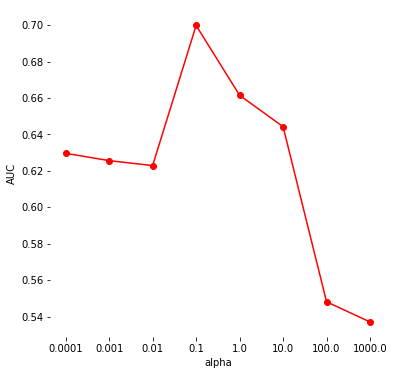

SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.6998070438805777


In [83]:
bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           X_train, y_train, X_test, y_test, 
           metric = roc_auc_score, greater_is_better=True,
           scoreLabel = "AUC")
print(bestModel, bestScore)

In [84]:
model = SGDClassifier(alpha=1.0, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [85]:
model.fit(X_train, y_train)

SGDClassifier(alpha=1.0, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [86]:
predicted_SGD = model.predict(X_test)

In [87]:
np.mean(predicted_SGD == y_test)

0.7542759407069556

In [88]:
model.score(X_test, y_test)

0.7542759407069556

In [89]:
confusion_matrix(y_test, predicted_SGD, labels=None, sample_weight=None)

array([[22043,   405],
       [ 6922,   448]])

## Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [91]:
clf=RandomForestClassifier(n_estimators=100)

In [92]:
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [93]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8805084177342545


In [94]:
confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

array([[21935,   513],
       [ 3050,  4320]])

In [95]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,21935,513,22448
1,3050,4320,7370
All,24985,4833,29818


In [96]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92     22448
           1       0.89      0.59      0.71      7370

   micro avg       0.88      0.88      0.88     29818
   macro avg       0.89      0.78      0.82     29818
weighted avg       0.88      0.88      0.87     29818



In [97]:
print(clf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [98]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 800, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [99]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [101]:
# rf_random.best_params_

## Best parameters from random grid search
{'n_estimators': 207,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [102]:
clf_best=RandomForestClassifier(n_estimators = 207,
 min_samples_split = 5,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = None,
 bootstrap = False)
clf_best.fit(X_train,y_train)

y_pred_best=clf_best.predict(X_test)

In [103]:
print("Accuracy:",accuracy_score(y_test, y_pred_best))

Accuracy: 0.889026762358307


In [104]:
confusion_matrix(y_test, y_pred_best, labels=None, sample_weight=None)

array([[21928,   520],
       [ 2789,  4581]])

Improved from 88.1% to 88.95% accuracy

In [105]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     22448
           1       0.90      0.62      0.73      7370

   micro avg       0.89      0.89      0.89     29818
   macro avg       0.89      0.80      0.83     29818
weighted avg       0.89      0.89      0.88     29818



In [106]:
pd.crosstab(y_test, y_pred_best, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,21928,520,22448
1,2789,4581,7370
All,24717,5101,29818


In [107]:
feature_importances = pd.DataFrame(clf_best.feature_importances_,
                                  index = X_train.columns,
                                  columns = ['importance']).sort_values('importance', ascending = False)

In [124]:
feature_importances.index.values

array(['cv_count', 'claim_level_word_count', 'iv_count', 'inj_count',
       'damage_desc_word_count', 'exposure_word_count', 'insured_count',
       'liability_count', 'accident_desc_word_count', 'insd_count',
       'injury_desc_word_count', 'ac_count', 'rear_count', 'vnop_count',
       'div_count', 'head_count', 'dcv_count', 'whiplash_count',
       'concussion_count', 'ambulance_count', 'deployed_count',
       'towed_count', 'totaled_count'], dtype=object)

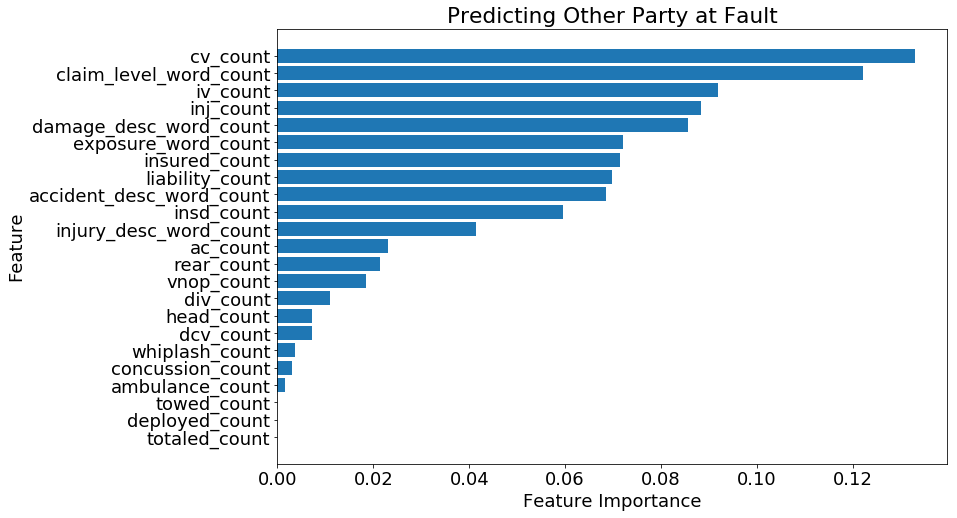

In [143]:
plt.barh(feature_importances.sort_values(by = 'importance').index.values, feature_importances\
         .sort_values(by = 'importance').importance.values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Predicting Other Party at Fault');

- cv_count: Number of times `cv` is used in Claim Level Body
- claim_level_word_count: Number of words in Claim Level Body
- iv_count: Number of times `iv` is used in Claim Level Body
- inj_count: Number of times `inj` is used in Claim Level Body
- damage_desc_word_count: Number of words in Damage Description
- exposure_word_count: Number of words in Exposure Level Body
- insured_count: Number of times `insured` is used in Claim Level Body
- liability_count: Number of times `liability` is used in Claim Level Body
- accident_desc_word_count: Number of words used in Accident Description
- insd_count: Number of times `insd` is used in Claim Level Body
- injury_desc_word_count: Number of words in Injury Description
- ac_count: Number of times `ac` is used in Claim Level Body
- rear_count: Number of times `rear` is used in Accident Description
- vnop_count: Number of times `vnop` is used in Claim Level Body
- div_count: Number of times `div` is used in Claim Level Body
- head_count: Number of times `head` is used in Injury Description
- dcv_count: Number of times `dcv` is used in Claim Level Body
- whiplash_count: Number of times `whiplash` is used in Injury Description
- concussion_count: Number of times `concussion` is used in Injury Description
- ambulance_count: Number of times `ambulance` is used in Injury Description

In [108]:
feature_importances

,importance
cv_count,0.132993
claim_level_word_count,0.122140
iv_count,0.091956
inj_count,0.088257
damage_desc_word_count,0.085552
exposure_word_count,0.072022
insured_count,0.071375
liability_count,0.069695
accident_desc_word_count,0.068549
insd_count,0.059506


## Random Forest Insured at Fault

In [133]:
X_insured = general_with_dummies.loc[:,'claim_level_word_count':'whiplash_count']
y_insured = general_with_dummies['Insured at fault']

In [134]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_insured, y_insured, 
                                                    test_size=0.25, random_state=42)

In [135]:
clf_i=RandomForestClassifier(n_estimators=150)

In [136]:
clf_i.fit(X_train_i,y_train_i)

y_pred_i=clf.predict(X_test_i)

In [137]:
print("Accuracy:",accuracy_score(y_test_i, y_pred_i))

Accuracy: 0.2380105976255953


In [138]:
confusion_matrix(y_test_i, y_pred_i, labels=None, sample_weight=None)

array([[ 6724,  4460],
       [18261,   373]])

In [139]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test_i, y_pred_i))

              precision    recall  f1-score   support

           0       0.27      0.60      0.37     11184
           1       0.08      0.02      0.03     18634

   micro avg       0.24      0.24      0.24     29818
   macro avg       0.17      0.31      0.20     29818
weighted avg       0.15      0.24      0.16     29818



## Sci-kit Learn Model

In [146]:
general_with_dummies.columns

Index(['claim_level_word_count', 'exposure_word_count',
       'accident_desc_word_count', 'injury_desc_word_count',
       'damage_desc_word_count', 'iv_count', 'liability_count', 'dcv_count',
       'inj_count', 'vnop_count', 'ac_count', 'cv_count', 'div_count',
       'insd_count', 'insured_count', 'rear_count', 'deployed_count',
       'towed_count', 'totaled_count', 'head_count', 'ambulance_count',
       'concussion_count', 'whiplash_count', 'Comparative Negligence',
       'Insured at fault', 'No fault', 'Other party at fault'],
      dtype='object')

In [147]:
X_sk = general_df.loc[:,'claim_level_list']
y_sk = general_with_dummies['Insured at fault']

In [148]:
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X_sk, y_sk, 
                                                    test_size=0.25, random_state=42)

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

In [151]:
clf_vec = TfidfVectorizer()

In [153]:
model = clf_vec.fit(X_train_sk, y_train_sk)

In [154]:
y_pred = model.predict(X_test_sk)

AttributeError: 'TfidfVectorizer' object has no attribute 'predict'

In [116]:
# model = text_clf.fit(X_train, y_train)

In [117]:
# predicted_MNB = text_clf.predict(X_test)

In [89]:
# predicted_MNB[:5]

In [90]:
# np.mean(predicted_MNB == y_test)

In [91]:
# len(predicted_MNB)

In [92]:
# text_clf.score(X_test, y_test)

In [93]:
# from collections import Counter

In [94]:
# Counter(predicted_MNB)

In [95]:
# 28402/29818

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(general_df.claim_level_list).toarray()
labels = general_df.FaultRatingName
features.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], 
                                                    random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)